In [1]:
#TODO: 
#      What query to use?
#      Can't specify two absolute points and a relative duration

# timeseries query

A Query defines a multivariate time series query on the Waylay timeseries database, and can be stored under a name as a Query Configuration.

These Query Configurations can be authored and tested on the console https://console.waylay.io/queries and be saved under a name. 

The `queries.query` resource in the Waylay Python SDK uses the queries backend REST services to read, create, update, delete and execute Query Configuration using a standardised JSON representation. 

A JSON definition of Query can also be executed without storing in a Configuration.

See https://docs.waylay.io/api/query/ or https://docs-io.waylay.io/#/features/query/ for more documentation.

## example usage
Import the client and check your backend connections

In [2]:
from waylay import WaylayClient
waylay_client = WaylayClient.from_profile('staging')

In [3]:
waylay_client.queries.about.version()

'v0.2.0+5.g43ae492'

... assuming you have previously saved a query under the `weather-data-query` name ...

`waylay_client.queries.query.get` fetches the query _definition_.

In [4]:
weather_data_temp = waylay_client.queries.query.get('weather-data-query')
weather_data_temp

{'until': 'now',
 'from': '2022-01-01',
 'data': [{'metric': 'temperature',
   'resource': 'weather_data',
   'aggregation': 'mean'}]}

By default, only the query definition is returned. If you want all metadata, use the `raw` parameter


In [5]:
waylay_client.queries.query.get('hvac_0001', raw=True).body

{'_links': {'self': {'href': 'https://api-staging.waylay.io/queries/v1/query/hvac_0001'},
  'execute': {'href': 'https://api-staging.waylay.io/queries/v1/data/hvac_0001'}},
 'attrs': {'created': '2021-06-16T12:53:27.649697+00:00',
  'created_by': 'users/f0981778-feed-4d08-823e-dc65e2b8a502',
  'modified': '2021-09-30T15:13:42.732217+00:00',
  'modified_by': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
  'path': '/tsa/query/hvac_0001'},
 'name': 'hvac_0001',
 'meta': {},
 'query': {'from': '2021-02-22T14:35:10Z',
  'data': [{'metric': 'temperature', 'resource': 'r_489784'},
   {'metric': 'occupancy', 'resource': 'r_489784'},
   {'metric': 'humidity', 'resource': 'r_489784'}]}}

To execute the saved query, use the `data` operation.

By default, this returns a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which render nicely in jupyter notebooks and have built-in support for plots.

In [6]:
df_now = waylay_client.queries.query.execute('weather-data-query', params={"from":"2022-01-01"}, timeout=2000)
df_now.head(5)

resource,weather_data
metric,temperature
timestamp,
2022-01-01 00:00:00+00:00,106
2022-01-01 00:47:00+00:00,110
2022-01-01 00:51:00+00:00,106
2022-01-01 01:51:00+00:00,111
2022-01-01 02:51:00+00:00,106


<AxesSubplot:xlabel='timestamp'>

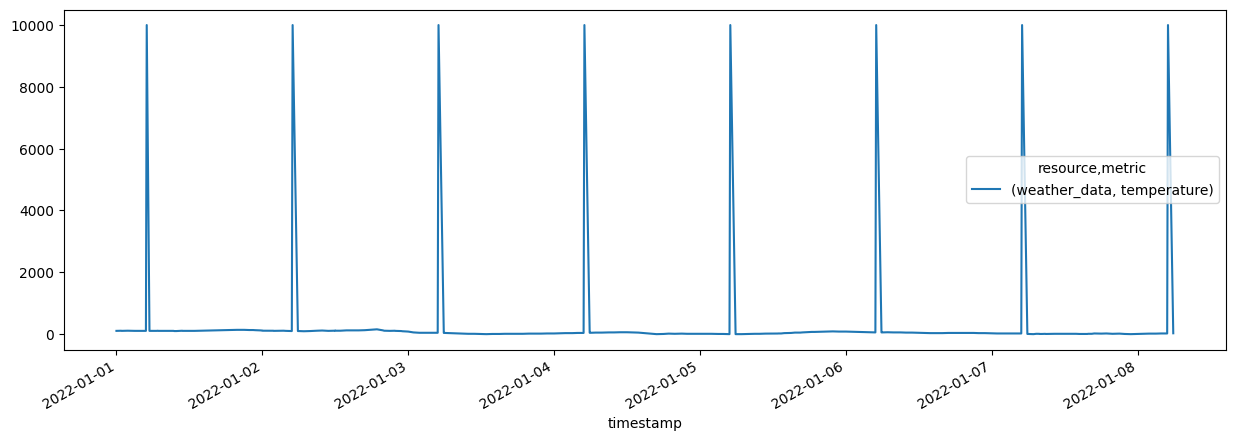

In [7]:
df_now.plot(figsize=(15,5))

You can override parameters of the query definition in a `params` argument.

In [8]:
df_2021_2022 = waylay_client.queries.query.execute('weather-data-query', params={
    'from': '2021-12-25','until':'2022-02-01'
})
df_2021_2022.describe()

resource,weather_data
metric,temperature
count,298.000000
mean,322.909396
std,1610.413219
min,0.000000
25%,17.000000
50%,44.000000
75%,106.000000
max,9999.000000


<AxesSubplot:xlabel='timestamp'>

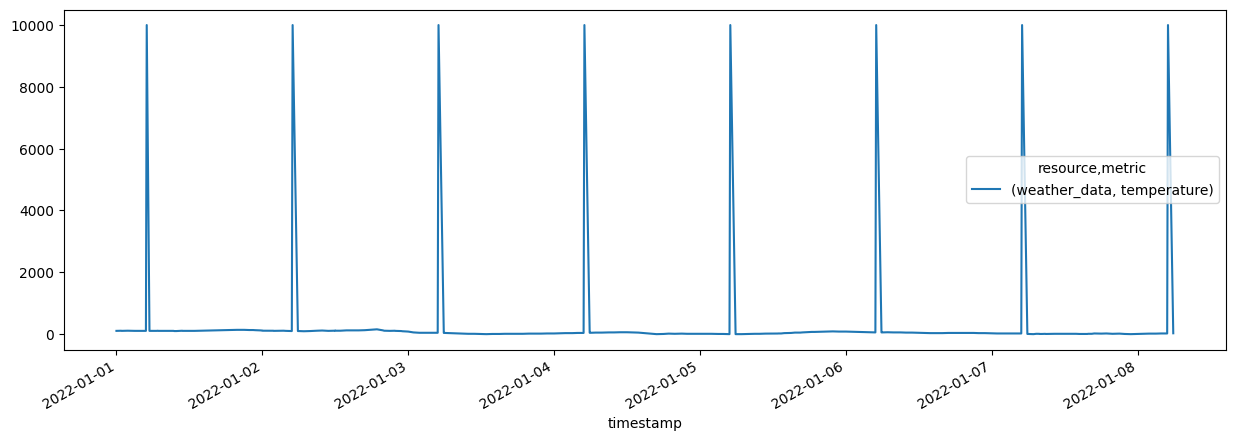

In [9]:
df_2021_2022.plot(figsize=(15,5))

You can suppress the conversion to dataframes by setting `response_constructor=False`.

In [10]:
waylay_client.queries.query.execute(
    'weather-data-query',
    params={'until':'2022-01-20'},
    response_constructor=False
)

[{'columns': ['timestamp',
   {'resource': 'weather_data', 'metric': 'temperature'}],
  'data': [[1640995200000, 106],
   [1640998020000, 110],
   [1640998260000, 106],
   [1641001860000, 111],
   [1641005460000, 106],
   [1641006000000, 106],
   [1641009060000, 106],
   [1641012000000, 106],
   [1641012660000, 106],
   [1641013140000, 9999],
   [1641014760000, 106],
   [1641015300000, 106],
   [1641016260000, 106],
   [1641016800000, 106],
   [1641018900000, 106],
   [1641019740000, 110],
   [1641019860000, 106],
   [1641022920000, 106],
   [1641023460000, 106],
   [1641026100000, 106],
   [1641027120000, 106],
   [1641027600000, 106],
   [1641028920000, 106],
   [1641029520000, 100],
   [1641030420000, 100],
   [1641030660000, 100],
   [1641034140000, 110],
   [1641034260000, 106],
   [1641037860000, 106],
   [1641038400000, 106],
   [1641041460000, 106],
   [1641045060000, 111],
   [1641048660000, 117],
   [1641049200000, 117],
   [1641052260000, 122],
   [1641055860000, 128],
   [1

You can build your own query config definitions, store them using `queries.query.create`, and execute them.

In [11]:
new_query_cfg_name = 'weather-data-demo'
new_query_cfg = { 
    'name': new_query_cfg_name,
    'query': {},
    'meta': { 'description': 'demo, modified version of weather-data-query'}
}
new_query = dict(weather_data_temp)
new_query_cfg['query'] = new_query
new_query['data'] = [ series for series in new_query['data'] if (series.get('metric') != 'other_metric') ]
new_query['until'] = '2022-02-01'
new_query['window'] = 'P30D'
new_query['from'] = None
new_query_cfg

{'name': 'weather-data-demo',
 'query': {'until': '2022-02-01',
  'from': None,
  'data': [{'metric': 'temperature',
    'resource': 'weather_data',
    'aggregation': 'mean'}],
  'window': 'P30D'},
 'meta': {'description': 'demo, modified version of weather-data-query'}}

We first delete any existing query config under that name

In [12]:
### need to delete any existing query config first
from waylay import RestResponseError
try: 
    waylay_client.queries.query.remove(new_query_cfg_name)
    print(f"'{new_query_cfg_name}' deleted")
except RestResponseError as exc:
    print(exc)

'weather-data-demo' deleted


In [13]:
waylay_client.queries.query.create(body=new_query_cfg)

{'until': '2022-02-01',
 'window': 'P30D',
 'data': [{'metric': 'temperature',
   'resource': 'weather_data',
   'aggregation': 'mean'}]}

<AxesSubplot:xlabel='timestamp'>

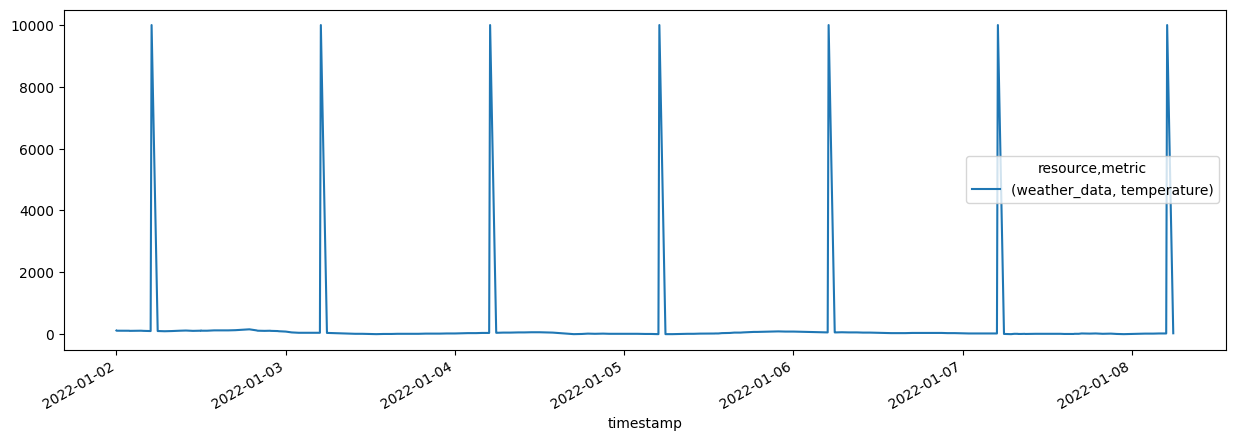

In [14]:
waylay_client.queries.query.execute(new_query_cfg_name).plot(figsize=(15,5))

a query config can be updated (the representation cannot have a name in it then)

<AxesSubplot:xlabel='timestamp'>

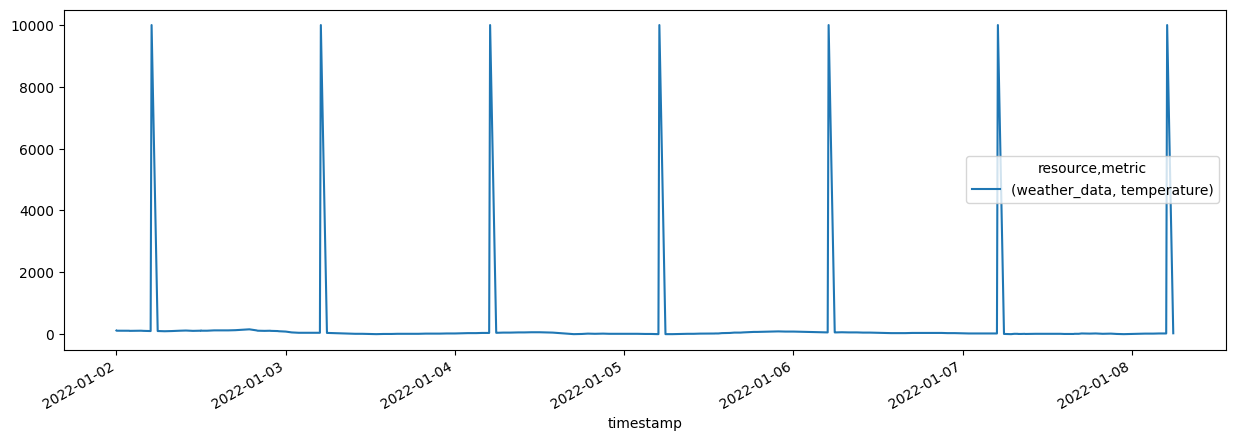

In [15]:
new_query['until'] = '2022-02-01'
waylay_client.queries.query.replace('weather-data-demo', body={'query': new_query})
waylay_client.queries.query.execute('weather-data-demo').plot(figsize=(15,5))

If a query does not need to be stored, you can use  `queries.query.execute` with the full query definition as first argument to execute it without saving.

In [16]:
waylay_client.queries.query.execute(new_query, params={'window':'P5D'})

resource,weather_data
metric,temperature
timestamp,
